**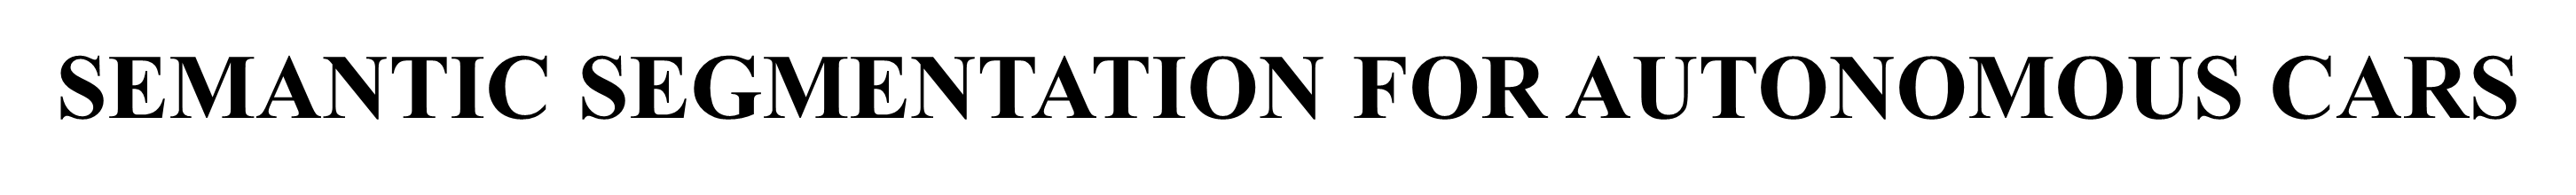**

***Problem Description***

The proposed project's ultimate aim is to implement the semantic segmentation for autonomous cars.


Semantic segmentation is a method of scene understanding in which classification is performed on every single pixel of an image. Semantic segmentation is used in autonomous vehicles to locate frontal objects such as roads, dividers, vehicles, pavements, etc. It is a vital subsystem of the vehicle's navigation system.

**Importing python libraries**

In [17]:
#importing python libraries
import numpy as np

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

In [18]:
import os
import numpy as np 
import pandas as pd 

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

**Creating lists and adding the image and mask data inside the list**

In [19]:
path = ''
image_path = os.path.join(path,"/content/drive/MyDrive/Sematic Segmentation for Autonomous Cars/CameraRGB")
mask_path = os.path.join(path, "/content/drive/MyDrive/Sematic Segmentation for Autonomous Cars/CameraSeg")
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+"/"+i for i in image_list]
mask_list = [mask_path+"/"+i for i in mask_list]

In [20]:
#Sorting the created lists
image_list = sorted(image_list)
mask_list = sorted(mask_list)
print("number of images is : {} ".format(len(image_list)))
image_list[:3]

number of images is : 1000 


['/content/drive/MyDrive/Sematic Segmentation for Autonomous Cars/CameraRGB/F61-1.png',
 '/content/drive/MyDrive/Sematic Segmentation for Autonomous Cars/CameraRGB/F61-10.png',
 '/content/drive/MyDrive/Sematic Segmentation for Autonomous Cars/CameraRGB/F61-100.png']

In [21]:
n = 5
img  = imageio.imread(image_list[n])
print(img.shape)
mask = imageio.imread(mask_list[n])
print(mask.shape)
mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

(600, 800, 3)
(600, 800, 3)


**Plotting the sample original and mask imgage data**

(600, 800, 3)

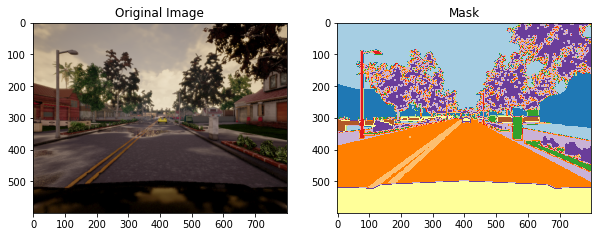

In [22]:
#displaying the Original image and mask images
fig ,arr  = plt.subplots(1,2,figsize=(10,6))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Mask')
(600, 800, 3)
(600, 800, 3)

In [23]:
import tensorflow as tf
image_list_dataset = tf.data.Dataset.list_files(image_list ,shuffle=False)
mask_list_dataset = tf.data.Dataset.list_files(mask_list , shuffle=False)

images_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((images_filenames
                                              ,masks_filenames))
for image,mask in dataset.take(1) : 
    print(image)
    print(mask)

tf.Tensor(b'/content/drive/MyDrive/Sematic Segmentation for Autonomous Cars/CameraRGB/F61-1.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Sematic Segmentation for Autonomous Cars/CameraSeg/F61-1.png', shape=(), dtype=string)


In [25]:
#imgae and maks lists are decoded and the data is readed 
#converting the image data into float values
def process_path(image_path,mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32) 
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask,channels=3)
    mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img , mask

In [26]:
# image and mask data are resized
def preprocess(image,mask) : 
    input_image = tf.image.resize(image,(256,256),method='nearest')
    input_mask = tf.image.resize(mask,(256,256),method='nearest')
    return input_image , input_mask

In [27]:
image_ds = dataset.map(process_path) 
print(image_ds)
processed_image_ds = image_ds.map(preprocess)

<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>


**Creating the Convolution layer of the CNN model**

**Inserting the maxpooling layer to reduce the dimensions of the data, inorder to increase the computational speed**

In [28]:
#defining the convolution block of the CNN model
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv) 
#activation function relu is used to process the output of the input layer, which is given to the hidden layers
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection


Convolutional decoding/upsampling block
    
  Arguments:
        inputs -- Input tensor from previous layer
        skip_connection_input -- Input tensor from previous skip layer
        filters -- Number of filters for the convolutional layers
  
  Returns: 
        C -- Tensor output
  

In [29]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
#creating the upsampling block which is used to double the inputs and increasing the dimensions which was reduced by the maxpooling layer
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

**Building the model**

In [30]:
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=23):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)     
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [31]:
#setting the image parameters for the model
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [32]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [33]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
EPOCHS = 10
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 16 # 16 number of samples are passed
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/10
63/63 [==============================] - 400s 3s/step - loss: 1.7441 - accuracy: 0.4840
Epoch 2/10
63/63 [==============================] - 22s 345ms/step - loss: 0.8298 - accuracy: 0.7380
Epoch 3/10
63/63 [==============================] - 22s 353ms/step - loss: 0.4843 - accuracy: 0.8567
Epoch 4/10
63/63 [==============================] - 22s 351ms/step - loss: 0.3204 - accuracy: 0.9044
Epoch 5/10
63/63 [==============================] - 22s 346ms/step - loss: 0.2916 - accuracy: 0.9124
Epoch 6/10
63/63 [==============================] - 22s 353ms/step - loss: 0.2344 - accuracy: 0.9283
Epoch 7/10
63/63 [==============================] - 22s 353ms/step - loss: 0.1942 - accuracy: 0.9389
Epoch 8/10
63/63 [==============================] - 22s 349ms/step - loss: 0.1697 - accuracy: 0.9463
Epoch 9/10
63/63 [==============================] - 22s 349ms/step - lo

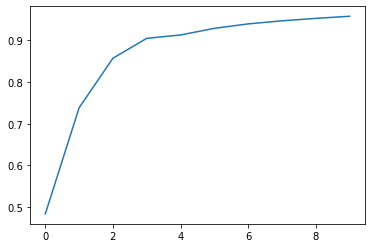

In [35]:
plt.plot(model_history.history["accuracy"])

In [36]:
def display(display_list):
  
    #Displays the first image of each of the num batches
  
    plt.figure(figsize=(15, 15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [37]:
#defining the mask images which was predicted by the model
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [38]:
def show_predictions(dataset=None, num=1):
    
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

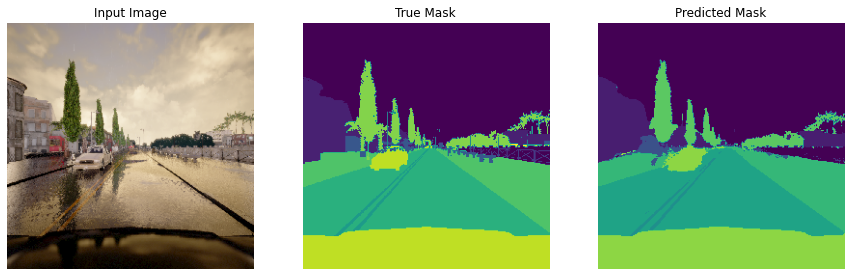

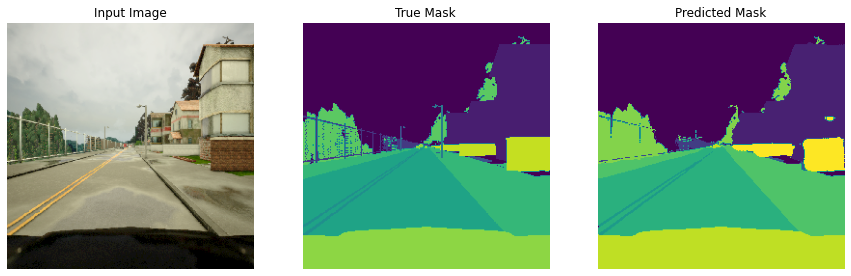

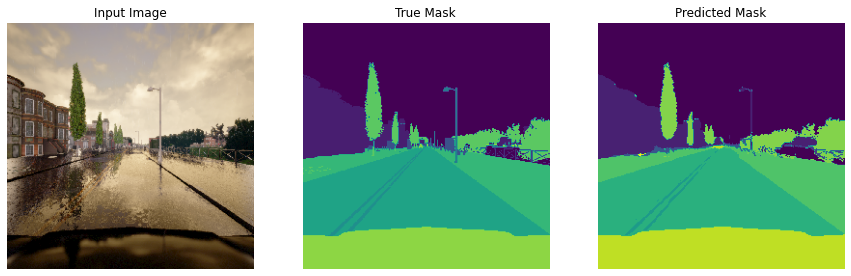

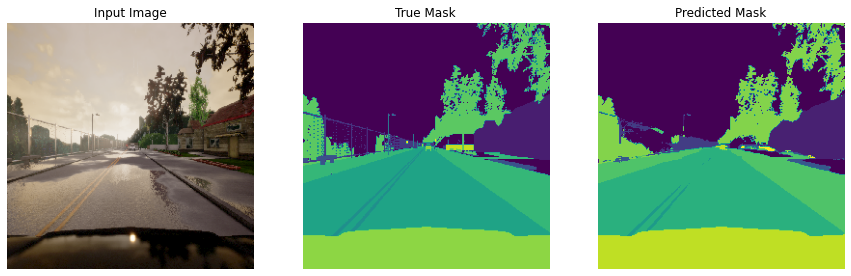

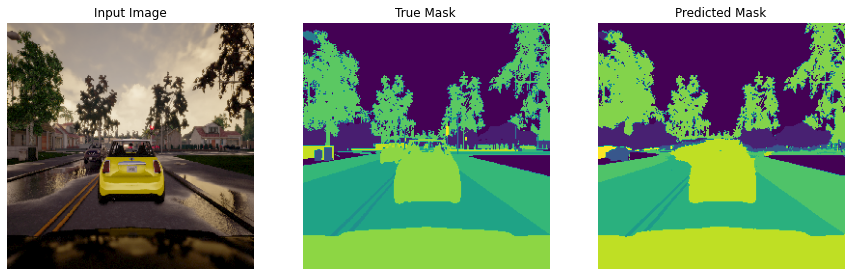

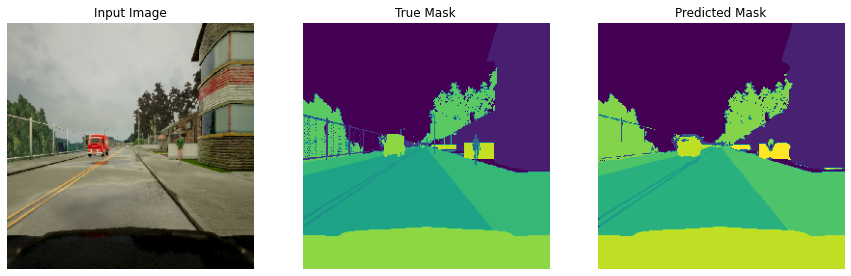

In [39]:
#diplaying the input images, true masks and predicted masks by the model

show_predictions(train_dataset, 6)

##***Creating a DeepLabV3+ model design*** 

In [40]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split

In [41]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
        )(block_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [42]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [43]:
def DeeplabV3(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    model_one = tf.keras.Model(inputs=model_input, outputs=model_output)
    
    return model_one

In [55]:
img_height = 256
img_width = 256
num_channels = 3
filters = 32
n_classes = 23

model_one = DeeplabV3(img_height, num_classes=23)
model_one.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [56]:
model_one.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
batch_size = 32
epochs = 30

In [57]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
validation_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [59]:
history = model_one.fit(train_dataset, 
                    validation_data = validation_dataset, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [callback, reduce_lr], 
                    batch_size = batch_size, 
                    shuffle = True)

Epoch 1/30
63/63 [==============================] - 58s 853ms/step - loss: 1.0018 - accuracy: 0.6870 - val_loss: 6.1713 - val_accuracy: 0.3922 - lr: 0.0010
Epoch 2/30
63/63 [==============================] - 32s 507ms/step - loss: 0.5709 - accuracy: 0.6866 - val_loss: 10.1670 - val_accuracy: 0.3173 - lr: 0.0010
Epoch 3/30
63/63 [==============================] - 32s 506ms/step - loss: 0.6260 - accuracy: 0.6913 - val_loss: 5.3167 - val_accuracy: 0.6181 - lr: 0.0010
Epoch 4/30
63/63 [==============================] - 32s 505ms/step - loss: 0.5581 - accuracy: 0.7552 - val_loss: 3.1942 - val_accuracy: 0.6557 - lr: 0.0010
Epoch 5/30
63/63 [==============================] - 32s 505ms/step - loss: 0.4852 - accuracy: 0.7564 - val_loss: 4.2880 - val_accuracy: 0.6261 - lr: 0.0010
Epoch 6/30
63/63 [==============================] - 32s 504ms/step - loss: 0.4494 - accuracy: 0.7732 - val_loss: 4.3105 - val_accuracy: 0.6422 - lr: 0.0010
Epoch 7/30
63/63 [==============================] - 32s 505ms/s

Text(0.5, 1.0, 'Accuracy of the model')

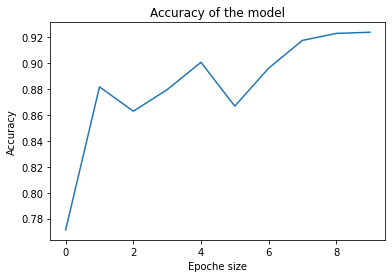

In [51]:
plt.plot(history.history["accuracy"])
plt.xlabel("Epoche size")
plt.ylabel("Accuracy")
plt.title("Accuracy of the model")

In [52]:
def display(disp_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(disp_list)):
        plt.subplot(1, len(disp_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(disp_list[i]))
        plt.axis('off')
    plt.show()

In [53]:
def show_predictions(dataset, num):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model_one.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model_one.predict(sample_image[tf.newaxis, ...]))])

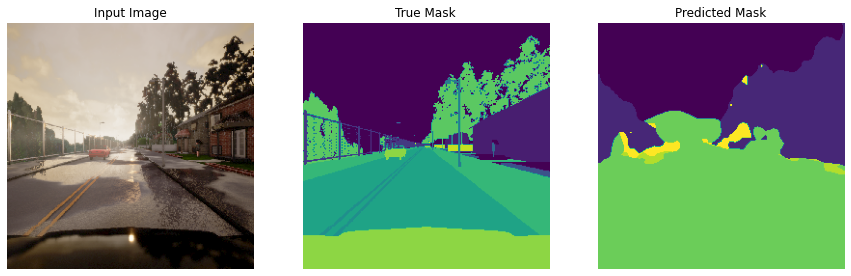

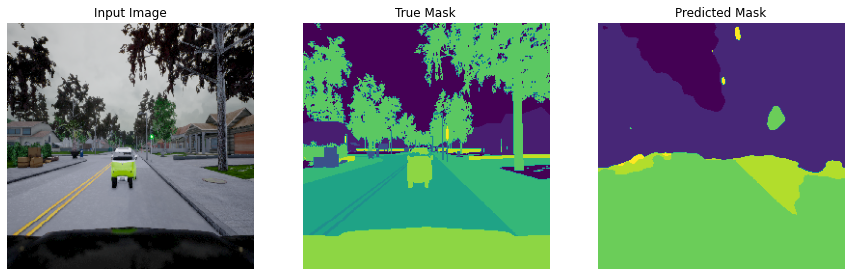

In [54]:
show_predictions(train_dataset, 2)